In [22]:
import gymnasium as gym
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import random
import math
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
def image_preprocessing(img):
  img = cv2.resize(img, dsize=(84, 84))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
  return img

In [24]:
class CarEnvironment(gym.Wrapper):
  def __init__(self, env, skip_frames=2, stack_frames=4, no_operation=5, **kwargs):
    super().__init__(env, **kwargs)
    self._no_operation = no_operation
    self._skip_frames = skip_frames
    self._stack_frames = stack_frames

  def reset(self):
    observation, info = self.env.reset()

    for i in range(self._no_operation):
      observation, reward, terminated, truncated, info = self.env.step(0)

    observation = image_preprocessing(observation)
    self.stack_state = np.tile(observation, (self._stack_frames, 1, 1))
    return self.stack_state, info


  def step(self, action):
    total_reward = 0
    for i in range(self._skip_frames):
      observation, reward, terminated, truncated, info = self.env.step(action)
      total_reward += reward
      if terminated or truncated:
        break

    observation = image_preprocessing(observation)
    self.stack_state = np.concatenate((self.stack_state[1:], observation[np.newaxis]), axis=0)
    return self.stack_state, total_reward, terminated, truncated, info

In [25]:
class CNN(nn.Module):
  def __init__(self, in_channels, out_channels, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self._n_features = 32 * 9 * 9

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2),
        nn.ReLU(),
    )

    self.fc = nn.Sequential(
        nn.Linear(self._n_features, 256),
        nn.ReLU(),
        nn.Linear(256, out_channels),
    )


  def forward(self, x):
    x = self.conv(x)
    x = x.view((-1, self._n_features))
    x = self.fc(x)
    return x

In [26]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
import heapq

class PrioritizedReplayMemory(ReplayMemory):
    def push(self, *args, priority):
        heapq.heappush(self.memory, (-priority, Transition(*args)))

    def sample(self, batch_size):
        return [heapq.heappop(self.memory)[1] for _ in range(batch_size)]


In [28]:
class DQN:
  def __init__(self, action_space, batch_size=512, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=500, lr=0.0001):
    self._n_observation = 4
    self._n_actions = 5
    self._action_space = action_space
    self._batch_size = batch_size
    self._gamma = gamma
    self._eps_start = eps_start
    self._eps_end = eps_end
    self._eps_decay = eps_decay
    self._lr = lr
    self._total_steps = 0
    self._evaluate_loss = []
    self.network = CNN(self._n_observation, self._n_actions).to(device)
    self.target_network = CNN(self._n_observation, self._n_actions).to(device)
    self.target_network.load_state_dict(self.network.state_dict())
    self.optimizer = optim.AdamW(self.network.parameters(), lr=self._lr, amsgrad=True)
    self._memory = ReplayMemory(10000)

    
  def select_action(self, state, evaluation_phase=False):

    # Generating a random number for eploration vs exploitation
    sample = random.random()

    # Calculating the threshold - the more steps the less exploration we do
    eps_threshold = self._eps_end + (self._eps_start - self._eps_end) * math.exp(-1. * self._total_steps / self._eps_decay)
    self._total_steps += 1

    if evaluation_phase:
      with torch.no_grad():
        return self.target_network(state).max(1).indices.view(1, 1)
    elif sample > eps_threshold:
      with torch.no_grad():
        return self.network(state).max(1).indices.view(1, 1)
    else:
      return torch.tensor([[self._action_space.sample()]], device=device, dtype=torch.long)

  def train(self):

    if len(self._memory) < self._batch_size:
        return

    # Initializing our memory
    transitions = self._memory.sample(self._batch_size)

    # Initializing our batch
    batch = Transition(*zip(*transitions))

    # Saving in a new tensor all the indices of the states that are non terminal
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

    # Saving in a new tensor all the non final next states
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Feeding our Q network the batch with states and then we gather the Q values of the selected actions
    state_action_values = self.network(state_batch).gather(1, action_batch)

    # We then, for every state in the batch that is NOT final, we pass it in the target network to get the Q'-values and choose the max one
    next_state_values = torch.zeros(self._batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1).values

    # Computing the expecting values with: reward + gamma * max(Q')
    expected_state_action_values = (next_state_values * self._gamma) + reward_batch

    # Defining our loss criterion
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Updating with back propagation
    self.optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
    self.optimizer.step()

    self._evaluate_loss.append(loss.item())

    return

  def copy_weights(self):
      #self.target_network.load_state_dict(self.network.state_dict())
      if self._total_steps % 200 == 0:  # 200 스텝마다 업데이트
          self.target_network.load_state_dict(self.network.state_dict())

  def get_loss(self):
    return self._evaluate_loss

  def save_model(self, i):
    torch.save(self.target_network.state_dict(), f'model_weights_{i}.pth')

  def load_model(self, i):
    self.target_network.load_state_dict(torch.load(f'model_weights_{i}.pth', map_location=device,weights_only=False))

In [29]:
def plot_statistics(x, y, title, x_axis, y_axis):
    plt.plot(x, y)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_")}.png')  # 공백 대신 밑줄 사용
    plt.show()
     

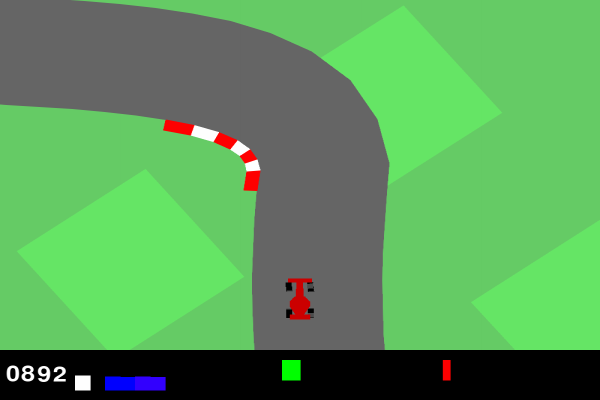

885.9014598539958


In [32]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = CarEnvironment(eval_env)
n_actions = eval_env.action_space
agent = DQN(n_actions)
agent.load_model(1000)

frames = []
scores = 0
s, _ = eval_env.reset()

eval_env.np_random = np.random.default_rng(42)

done, ret = False, 0

from PIL import Image as PILImage
def render2img(_img): return PILImage.fromarray(_img, "RGB")
handle = display(None, display_id=True)
while not done:
    _render = eval_env.render()
    handle.update(render2img(_render))
    frames.append(_render)
    s = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    a = agent.select_action(s, evaluation_phase=True)
    discrete_action = a.item() % 5
    s_prime, r, terminated, truncated, info = eval_env.step(discrete_action)
    s = s_prime
    ret += r
    done = terminated or truncated
    if terminated:
      print(terminated)
      
scores += ret

print(scores)



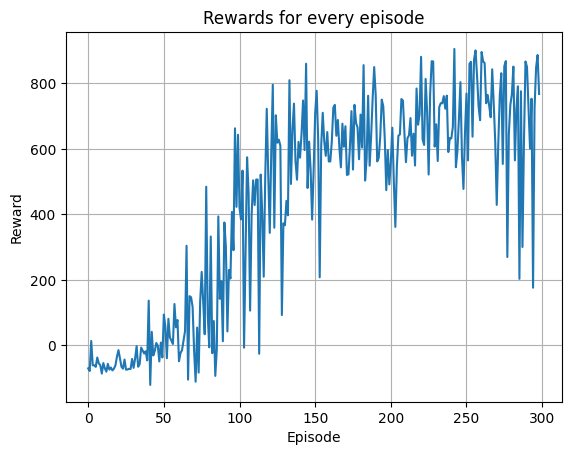

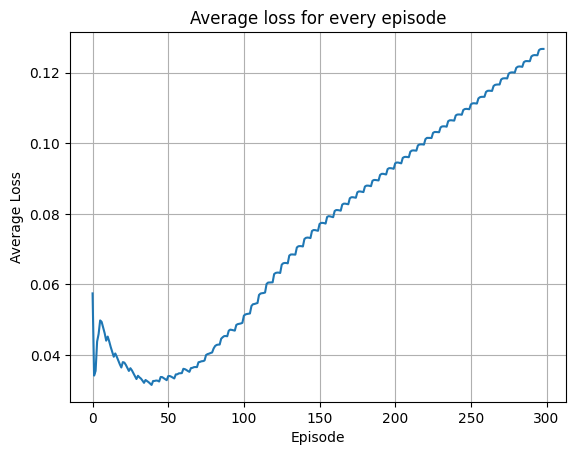

In [31]:
with open('statistics.pkl', 'rb') as f:
    data_tuple = pickle.load(f)

episode_duration, rewards_per_episode, average_episode_loss = data_tuple

x = [k for k in range(len(rewards_per_episode))]

rewards_per_episode = [tensor.cpu() if tensor.is_cuda else tensor for tensor in rewards_per_episode]

plot_statistics(x, rewards_per_episode, "Rewards for every episode", "Episode", "Reward")
plot_statistics(x, average_episode_loss, "Average loss for every episode", "Episode", "Average Loss")